In [1]:
# evaluate convlstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from matplotlib import pyplot

2024-04-16 11:35:36.285594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [3]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [4]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [5]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [6]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu',
    input_shape=(n_seq, 1, n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [7]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [8]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [9]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

In [10]:
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

 > 1584.160
 > 1462.227
 > 2049.864
 > 1395.664
 > 1189.880
 > 1452.083
 > 1980.027
 > 1824.147
 > 1873.494
 > 1996.272
 > 1850.640
 > 1871.470
 > 1966.044
 > 1686.461
 > 1655.969
 > 1714.933
 > 2391.965
 > 1649.417
 > 1597.961
 > 1367.153
 > 1732.175
 > 1495.320
 > 1393.078
 > 1754.200
 > 1702.736
 > 1932.073
 > 2141.193
 > 1403.609
 > 1260.184
 > 1539.167
convlstm: 1697.119 RMSE (+/- 273.353)


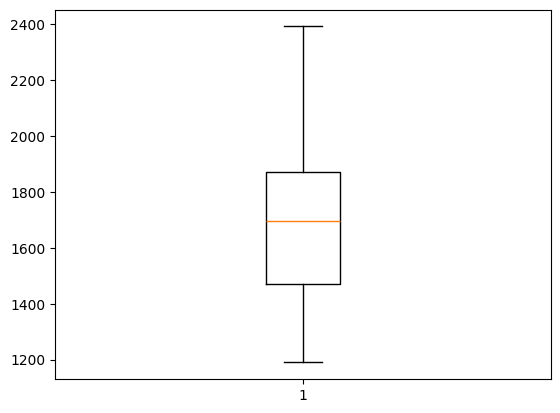

In [11]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 256, 3, 200, 200, 100]
n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('convlstm', scores)